# Testing impact of using a different mask_token ([MASK])


The default mask_token for text shap is `'...'` - not reasonable to substitute masked words with that. I tried using different mask_tokens: `''` (empty string) and `[MASK]` (which is the same mask_token used by the model's tokenizer)


+ model: `distilbert` (v1)
+ mask_token: `[MASK]`
+ data split: `test`

**!! Compare this notebook with `distilbert_shap_results.ipynb`**

(only difference is the mask_token; there it is the empty string)



In [20]:
import json
import os
import pandas as pd
import numpy as np
import pickle as pkl

PROJECT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
SHAP_DIR = os.path.join(PROJECT_DIR, 'classification/shap_values/coqa/')
MASK_DIR = os.path.join(SHAP_DIR, 'masktoken_mask_default')

Results from shap analysis stored in json files - eg.: 

`classification/shap_values/coqa/masktoken_mask_default/agg-sv_distilbert_class-avg_3gram_test_mask.json`

In [21]:
entity_frequency_dict = None # not needed here (but so we can use the exact same viz functions as in the other notebook)
entity_frequency_dict_mask = json.load(open(os.path.join(MASK_DIR, 'distilbert_entity_frequency_test_mask.json'), 'r'))

In [25]:
def visualize_shap_results(shap_file, n_features=10):

    freq_dict = entity_frequency_dict
    load_from_dir = SHAP_DIR
    entity_type = shap_file.split('_')[3]+'s'

    # Relevant for chunk-level shap values
    # Using different mask tokens leads to different chunks
    # + values derived with mask_token==[MASK] are in a different DIR
    if 'mask' in shap_file:
        freq_dict = entity_frequency_dict_mask
        load_from_dir = MASK_DIR

    if 'class-avg' in shap_file:
        with open(os.path.join(load_from_dir, shap_file), 'r') as f:
            shap_results = json.load(f)

        # Get frequency info and filter out tokens with frequency < 10
        sorted_neg = [
            (k, v) for k, v in sorted(shap_results.items(), key=lambda item: item[1][0])
            if freq_dict[entity_type][k] >= 10
        ]
        top_n_neg = sorted_neg[:n_features]
        neg_df = pd.DataFrame(top_n_neg, columns=['token', 'shap_values'])
        neg_df['shap_neg'] = neg_df['shap_values'].apply(lambda x: float(x[0]))
        neg_df['shap_pos'] = neg_df['shap_values'].apply(lambda x: float(x[1]))
        neg_df = neg_df.drop(columns=['shap_values'])
        
        sorted_pos = [
            (k, v) for k, v in sorted(shap_results.items(), key=lambda item: item[1][1])
            if freq_dict[entity_type][k] >= 10
        ]
        top_n_pos = sorted_pos[-n_features:]
        pos_df = pd.DataFrame(top_n_pos, columns=['token', 'shap_values'])
        pos_df['shap_neg'] = pos_df['shap_values'].apply(lambda x: float(x[0]))
        pos_df['shap_pos'] = pos_df['shap_values'].apply(lambda x: float(x[1]))
        pos_df = pos_df.drop(columns=['shap_values'])

        top_shap_values = pd.merge(neg_df, pos_df, how='outer')

        # add frequency info: add to name of token
        top_shap_values['token'] = top_shap_values['token'].apply(
            lambda x: x + f" ({freq_dict[entity_type][x]})"
        )

        top_shap_values.plot(x='token', y=['shap_neg', 'shap_pos'], kind='barh', figsize=(20, 10))
        
    else:
        with open(os.path.join(load_from_dir, shap_file), 'r') as f:
            shap_results = json.load(f)
        
        sorted_shap_results = {
            k: v for k, v in sorted(shap_results.items(), key=lambda item: item[1])
        }
        
        shap_df = pd.DataFrame(sorted_shap_results.items(), columns=['token', 'shap_value'])

        # add frequency column
        shap_df['frequency'] = shap_df['token'].apply(
            lambda x: freq_dict[entity_type][x]
        )
        # filter out tokens with frequency < 10
        shap_df = shap_df[shap_df['frequency'] >= 10]

        top_n_neg = shap_df.head(n_features)
        top_n_pos = shap_df.tail(n_features)
        top_shap_values = pd.merge(top_n_neg, top_n_pos, how='outer')

        # add frequency to name of token
        top_shap_values['token'] = top_shap_values['token'].apply(
            lambda x: x + f" ({freq_dict[entity_type][x]})"
        )
    
        top_shap_values.plot(x='token', y='shap_value', kind='barh', figsize=(20, 10))

    return top_shap_values

# Aggregations (global explanation)

## Token-level

### Overall avg

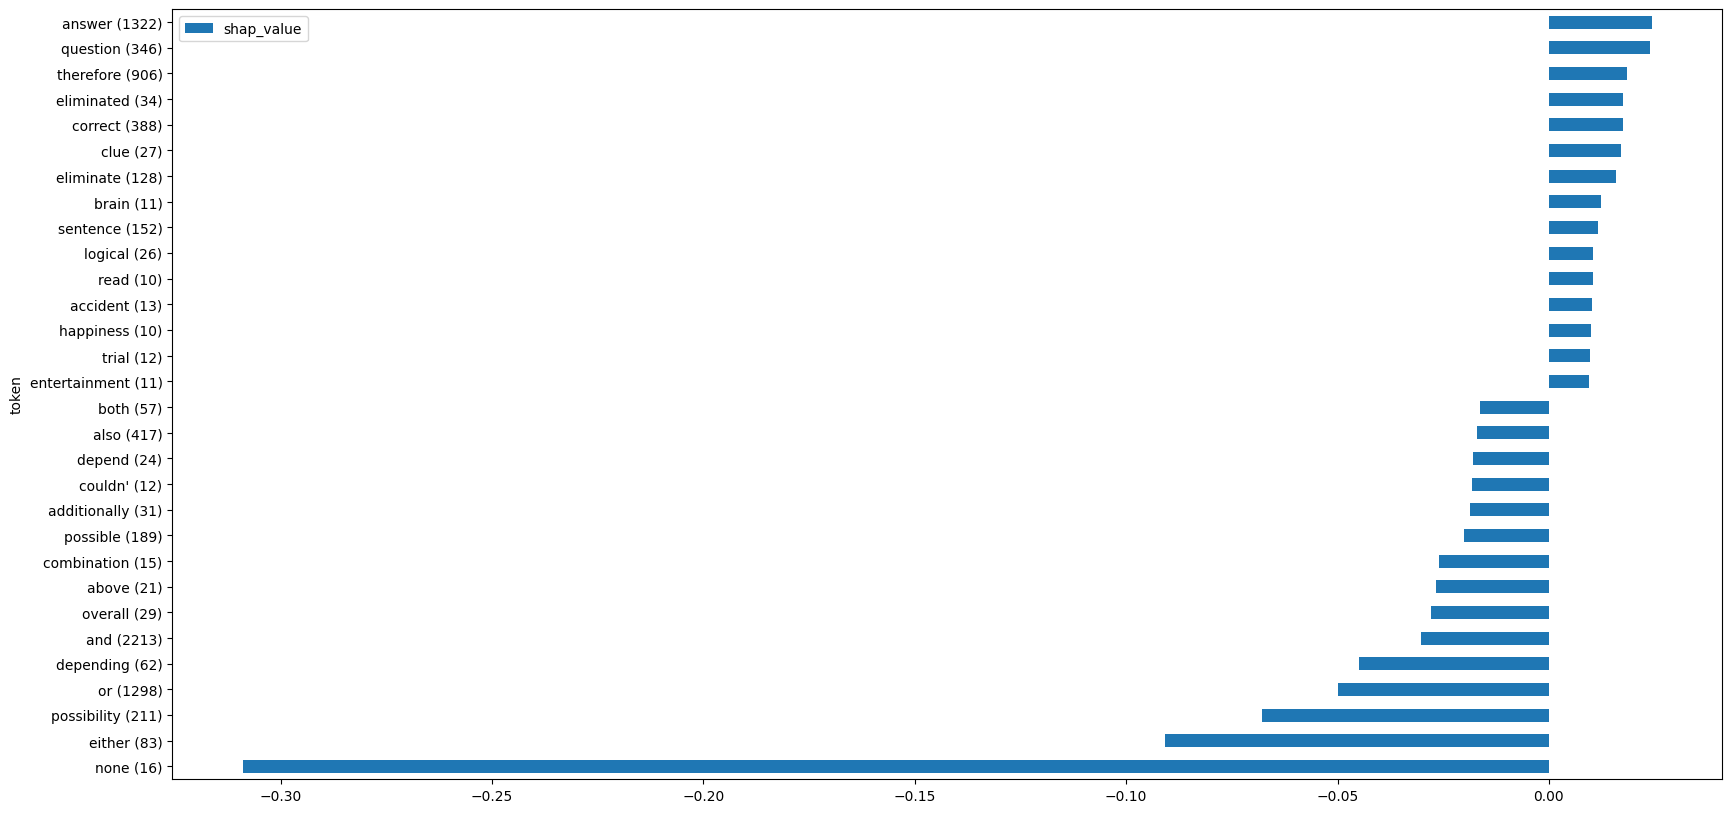

In [26]:
top_tokens_overall_mask = visualize_shap_results('agg-sv_distilbert_overall-avg_token_test_mask.json', n_features=15)

### Per class avg

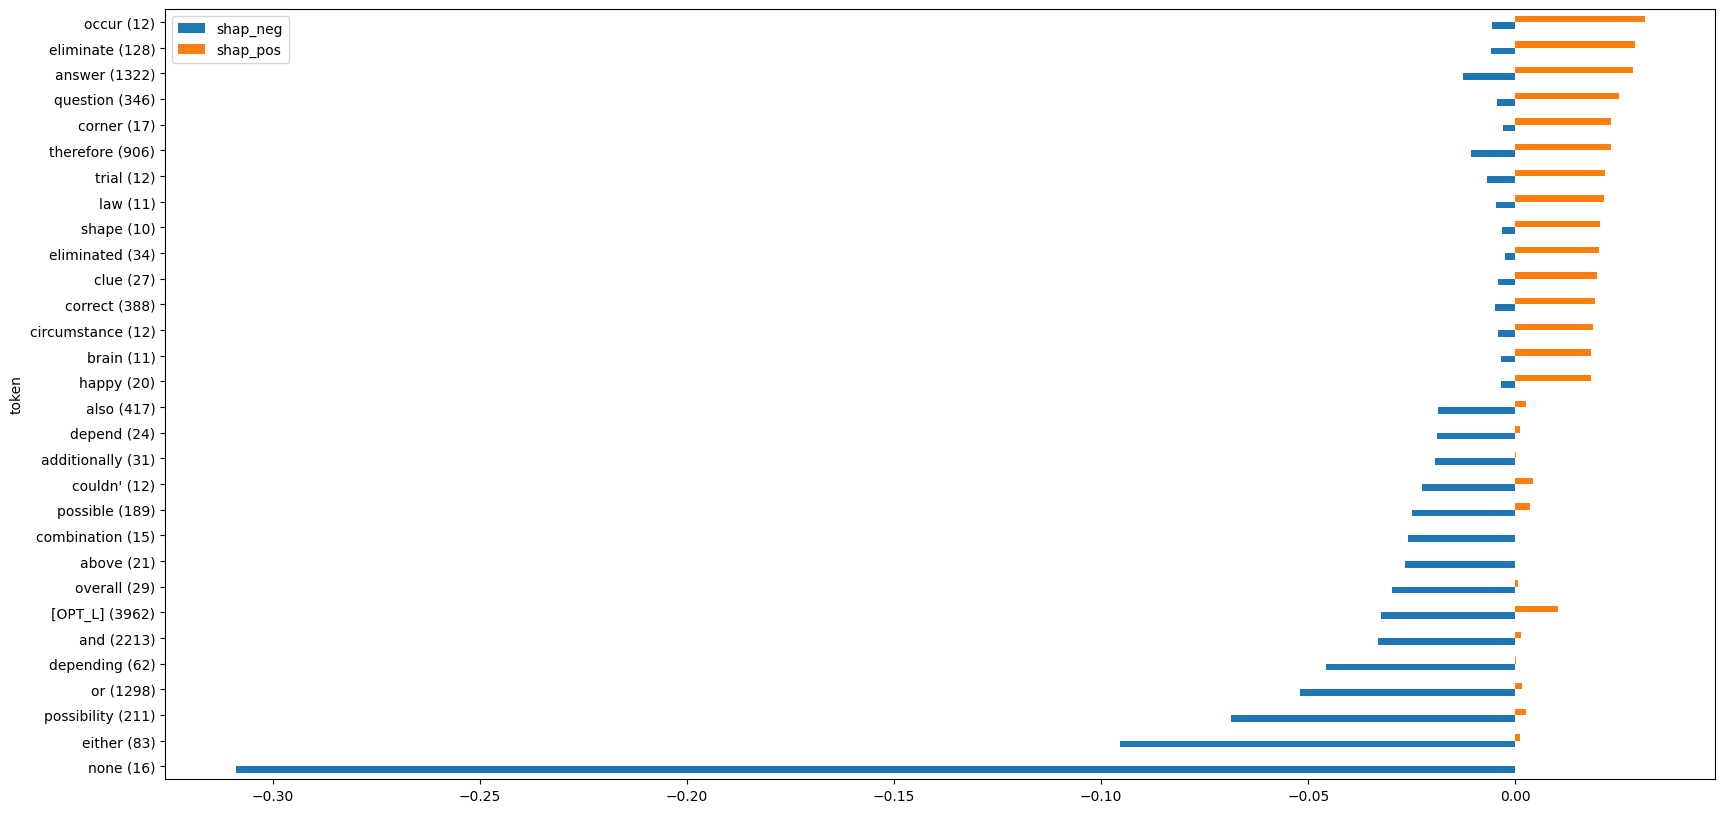

In [27]:
top_tokens_class_mask = visualize_shap_results('agg-sv_distilbert_class-avg_token_test_mask.json', n_features=15)

## 3gram-level

### Overall avg

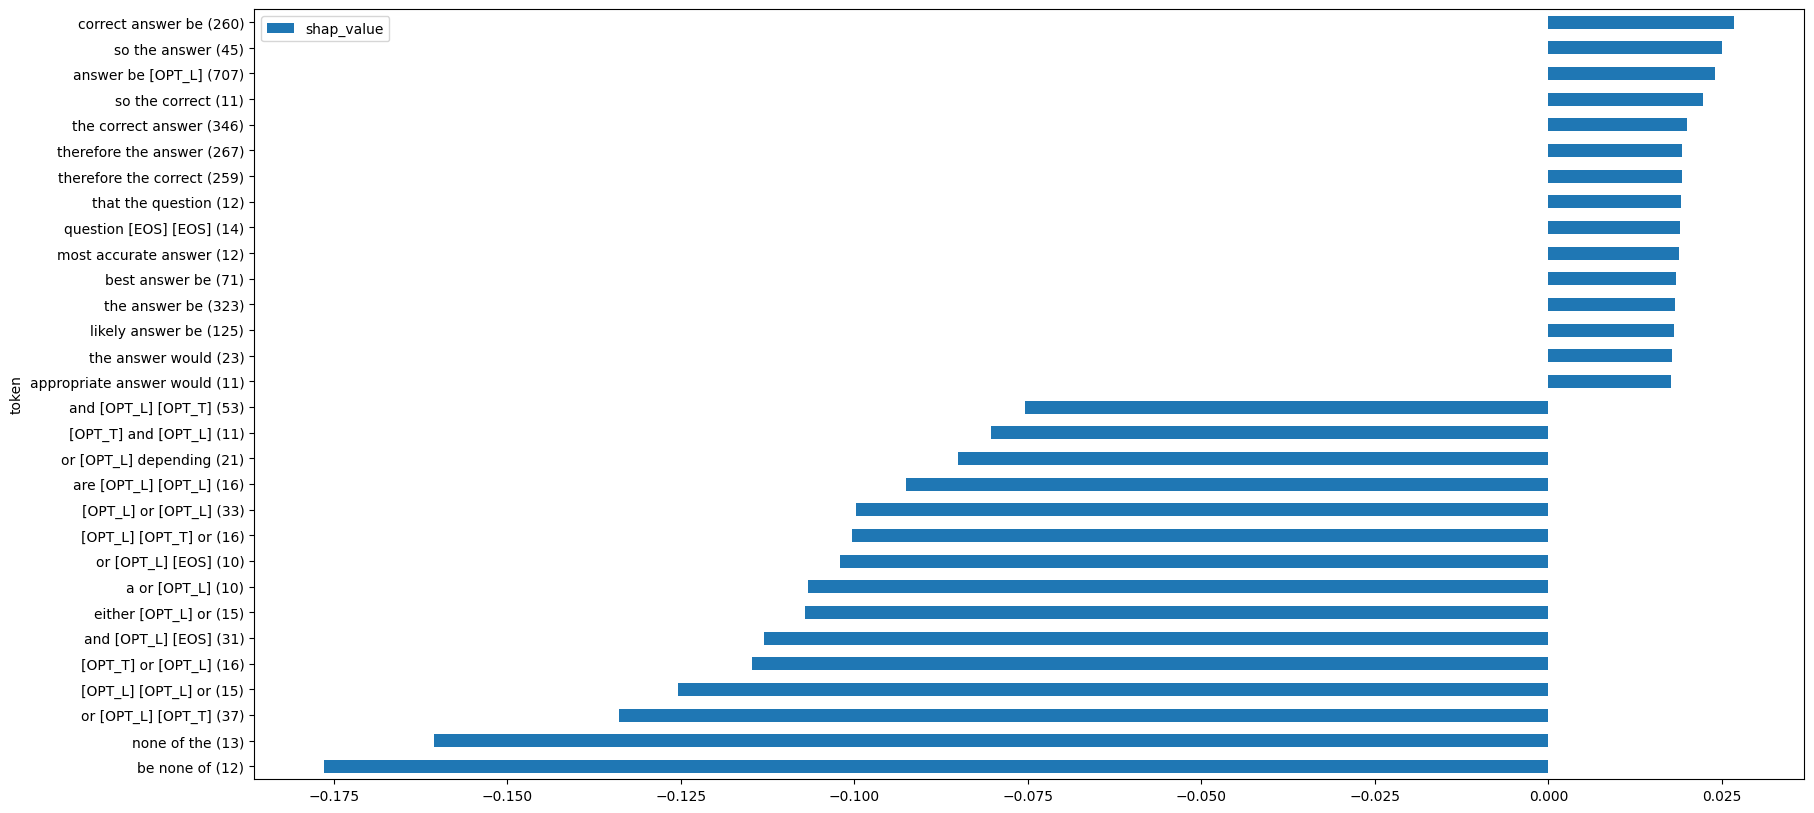

In [28]:
top_3grams_overall_mask = visualize_shap_results('agg-sv_distilbert_overall-avg_3gram_test_mask.json', n_features=15)

### Per class avg

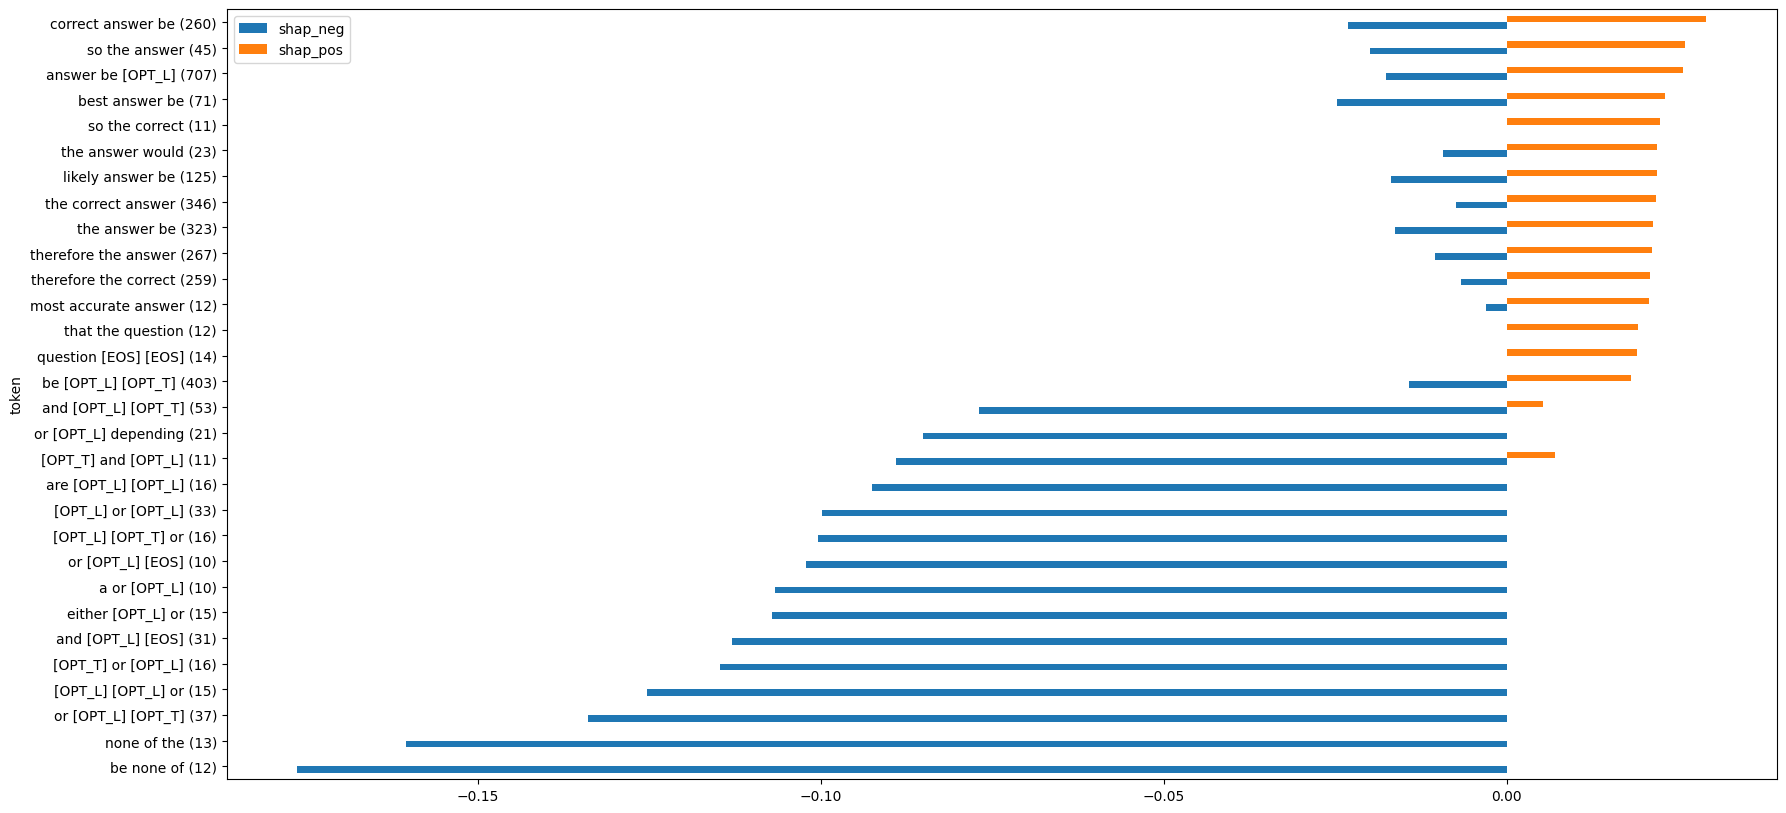

In [29]:
top_3grams_class_mask = visualize_shap_results('agg-sv_distilbert_class-avg_3gram_test_mask.json', n_features=15)

## 5gram-level

### Overall avg

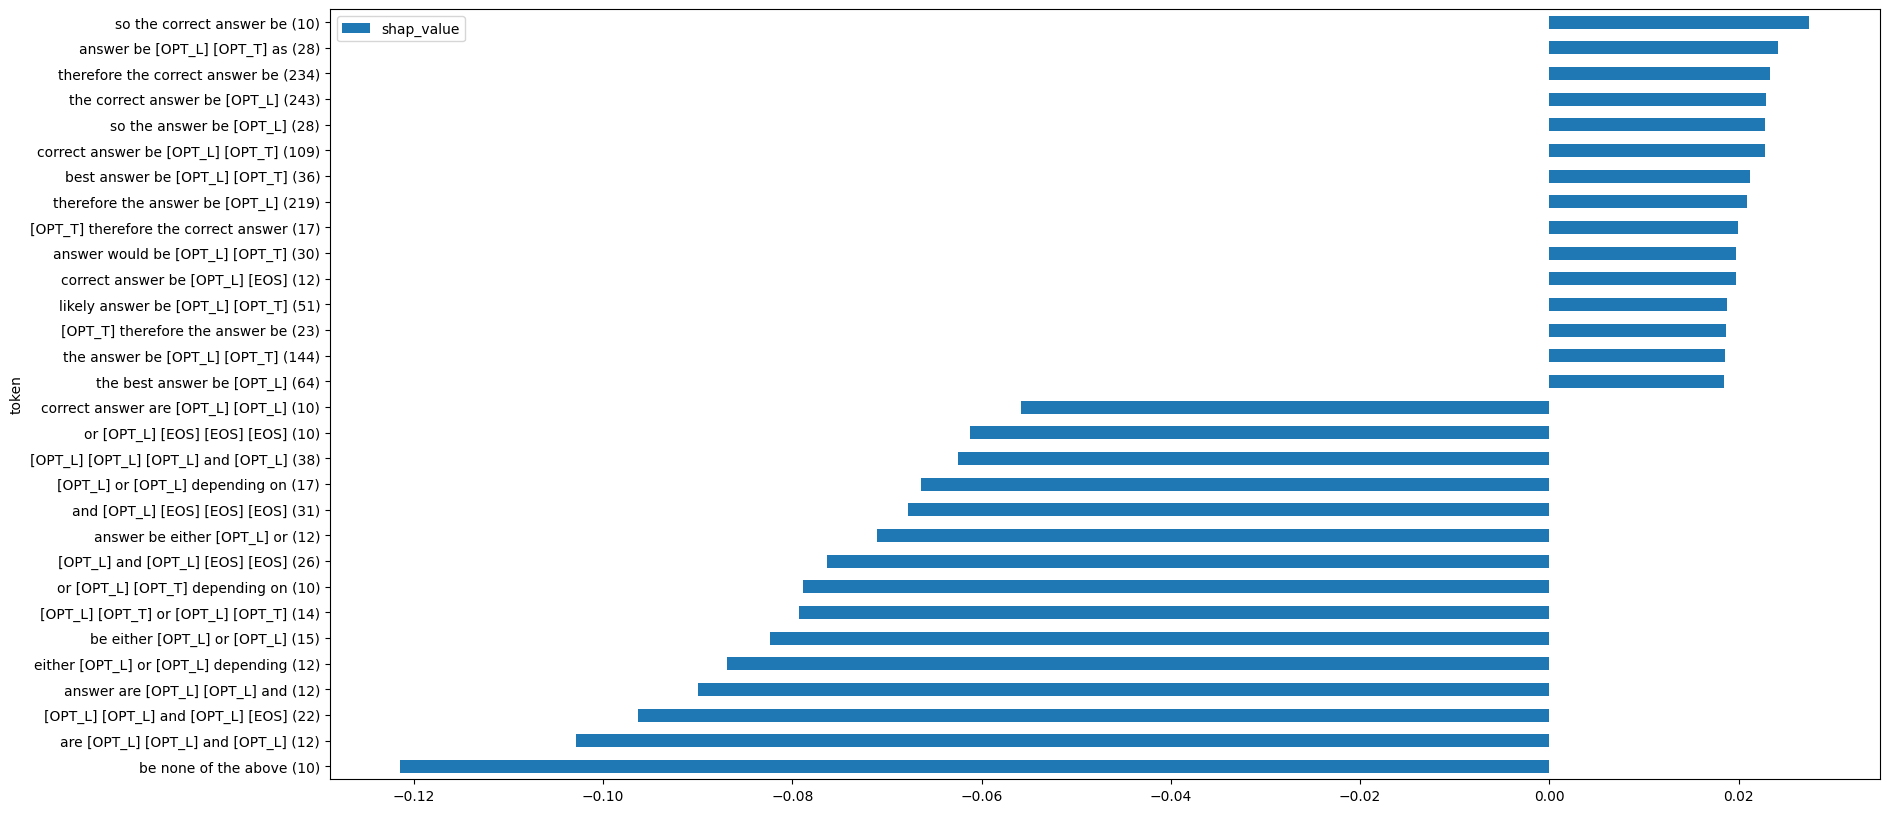

In [30]:
top_5grams_overall_mask = visualize_shap_results('agg-sv_distilbert_overall-avg_5gram_test_mask.json', n_features=15)

### Per class avg

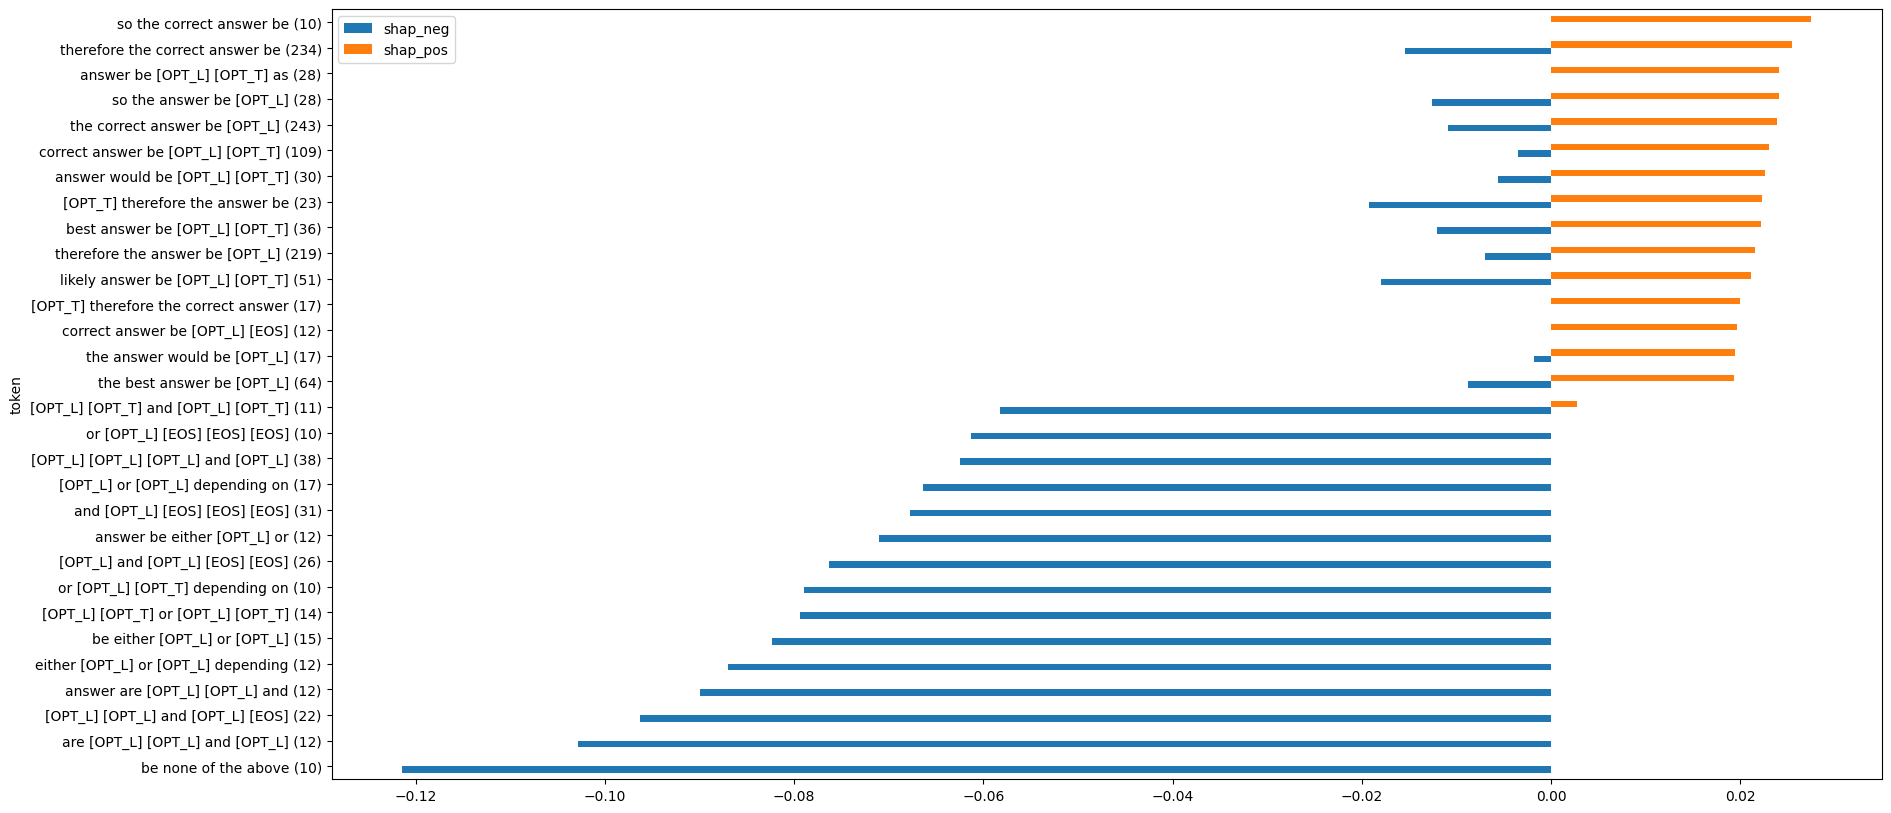

In [31]:
top_5grams_class_mask = visualize_shap_results('agg-sv_distilbert_class-avg_5gram_test_mask.json', n_features=15)

## Chunck-level

### Overall avg

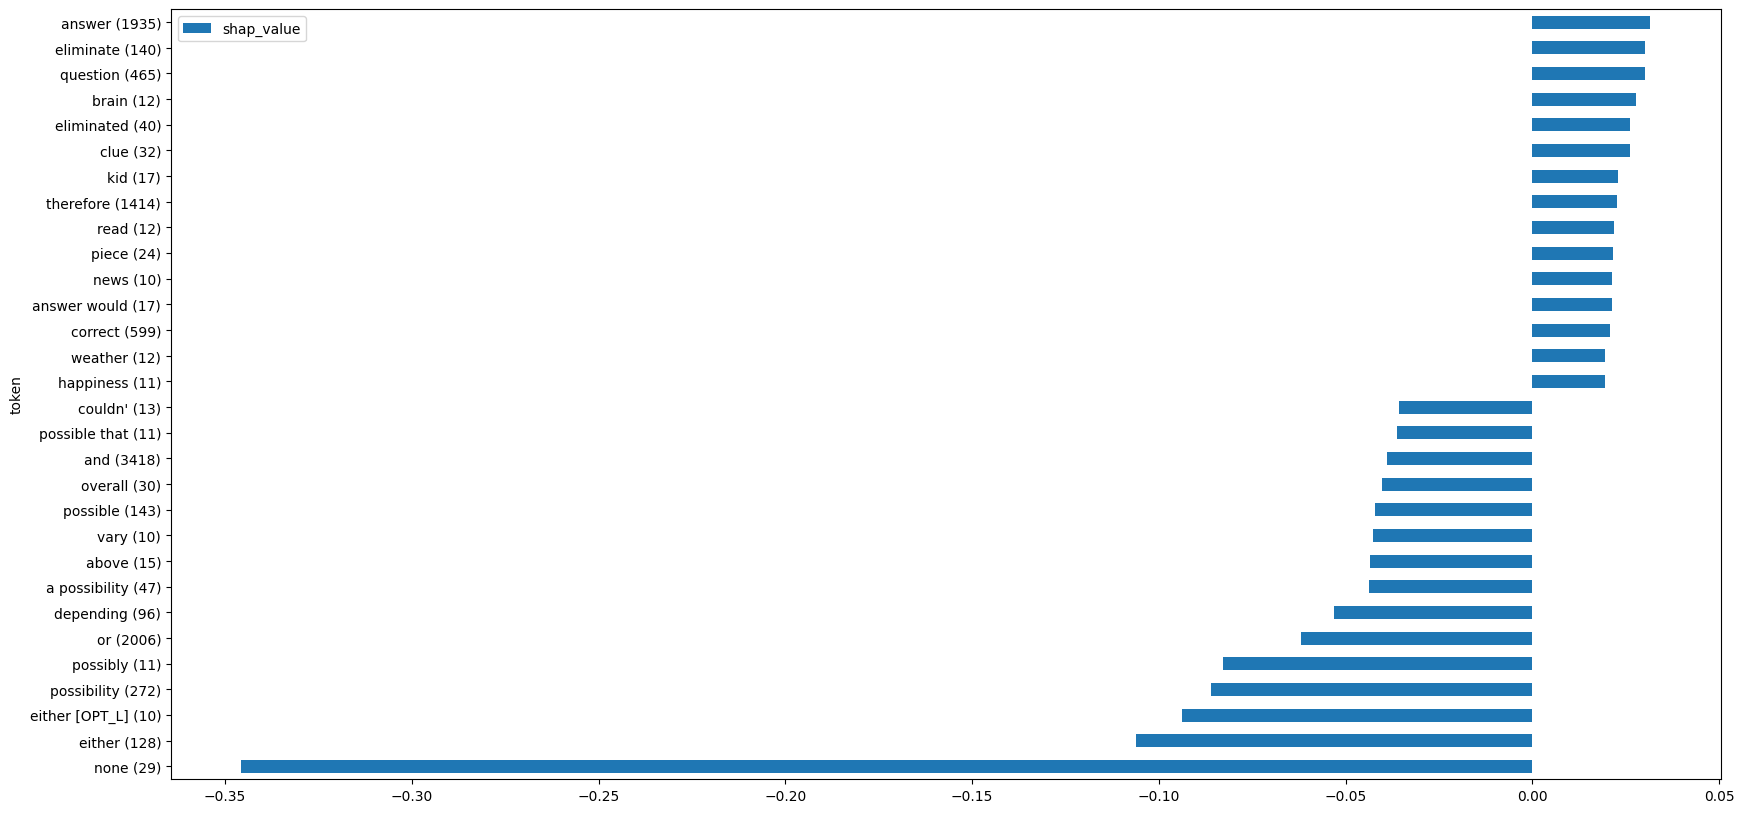

In [32]:
top_chunks_overall_mask = visualize_shap_results('agg-sv_distilbert_overall-avg_chunk_test_mask.json', n_features=15)

### Per class avg

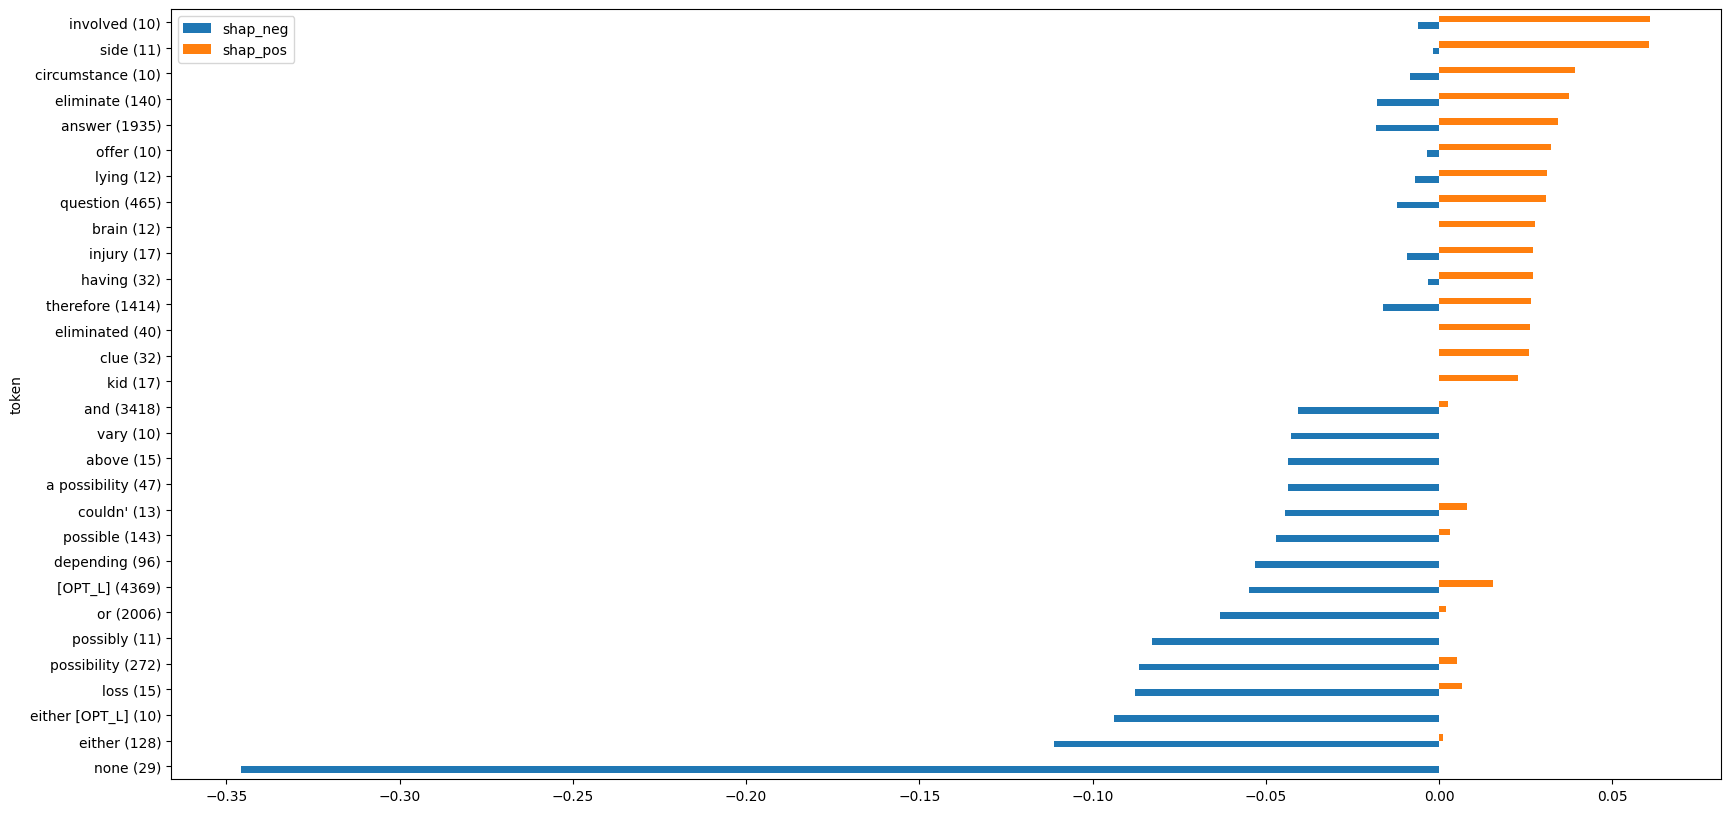

In [33]:
top_chunks_class_mask = visualize_shap_results('agg-sv_distilbert_class-avg_chunk_test_mask.json', n_features=15)

# Instance-level (local explanation)

to do...